In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple

from definitions import ROOT_DIR
from unc.utils import load_info

In [2]:
rg_lstm_path = Path(ROOT_DIR, 'results', 'rg_lstm')
rg_path = Path(ROOT_DIR, 'results', 'rg')
rxg_path = Path(ROOT_DIR, 'results', 'rxg')
rpg_path = Path(ROOT_DIR, 'results', 'rpg')
rsg_path = Path(ROOT_DIR, 'results', 'rsg')

split_by = ['buffer_size', 'step_size', 'algo', 'rock_obs_init']

rg_lstm_color = 'blue'
rg_color = 'black'
rxg_color = 'purple'
rsg_color = 'darkorange'
rpg_color = 'forestgreen'


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [4]:
load_info([d for d in rg_lstm_path.iterdir()][0])['args']

array({'slip_turn': False, 'algo': 'sarsa', 'log_dir': PosixPath('/scratch/taodav/uncertainty/log/rg'), 'max_episode_steps': 1000, 'rock_obs_init': 0.0, 'replay': True, 'arch': 'nn', 'random_start': True, 'results_fname': 'd1778aafa71d5a5557e4f491ed8966c9_Tue Oct 19 21:25:27 2021.npy', 'view_test_ep': False, 'size': 8, 'exploration': 'eps', 'n_hidden': 100, 'p_prefilled': 0.0, 'save_model': False, 'update_weight_interval': 1, 'seed': 2026, 'anneal_steps': 0, 'epsilon': 0.1, 'discounting': 0.99, 'results_dir': PosixPath('/scratch/taodav/uncertainty/results/rg'), 'buffer_size': 100000, 'test_eps': 0.0, 'n_particles': -1, 'trunc': 20, 'device': 'cpu', 'epsilon_start': 1.0, 'slip_prob': 0.1, 'batch_size': 64, 'env': 'rg', 'resample_interval': 1, 'step_size': 1e-05, 'total_steps': 1500000, 'blur_prob': 0.3},
      dtype=object)

In [4]:
def get_discounted_returns(ep_lengths, ep_rews, discount=0.99, maxlen=1000):
    assert ep_lengths.sum() == ep_rews.shape[0], f"Incompatible lengths and rews - lengths: {ep_lengths.sum()}, rews shape[0]: {ep_rews.shape[0]}"

    discounted_returns = []
    current_ep_disc_rew = 0
    idx = 0
    discounts = discount ** np.arange(maxlen)
    
    for ep_len in ep_lengths:
        curr_ep_rews = ep_rews[idx:idx + ep_len]
        current_ep_disc_rew = np.dot(curr_ep_rews, discounts[:ep_len])
        idx += ep_len
#         for i in range(ep_len):
#             current_ep_disc_rew += ep_rews[idx] * (discount ** i)
#             idx += 1
        discounted_returns.append(current_ep_disc_rew.astype(np.float32))
        current_ep_disc_rew = 0
    discounted_returns = np.array(discounted_returns)
    
    assert discounted_returns.shape[0] == ep_lengths.shape[0]
    
    return discounted_returns

In [20]:
def process_dir(dir_path, w=100, split_by=None, discount=0.99):

    if split_by is not None:
        Args = namedtuple('args', split_by)
        all_results = {}
    else:
        all_results = []
        
    for f in tqdm(list(dir_path.iterdir())):
        info = load_info(f)
        args = info['args'].item()
        
        if info['episode_length'].sum() != info['reward'].shape[0]:
            print(f"Incompatible lengths and rews - lengths: {info['episode_length'].sum()}, rews shape[0]: {info['reward'].shape[0]},\n file: {f}")
            continue
            

        result = get_discounted_returns(info['episode_length'], info['reward'], discount)

        if split_by is not None:
            hparams = Args(*tuple(args[s] for s in split_by))
            
            if hparams not in all_results:
                all_results[hparams] = []
                
            all_results[hparams].append((info['episode_length'], result))
            
        else:
            all_results.append((info['episode_length'], result))
        
        
            
#     if split_by is not None:
#         for k, v in all_results.items():
#             for k1, v1 in v.items():
#                 all_results[k][k1] = np.array(all_results[k][k1])
#         data = all_results
#     else:
#         data = np.array(all_results)

    
    return all_results


In [8]:
discount = 0.99
rg_data = process_dir(rg_path, split_by=split_by, discount=discount)
rxg_data = process_dir(rxg_path, split_by=split_by, discount=discount)
rpg_data = process_dir(rpg_path, split_by=split_by, discount=discount)
rsg_data = process_dir(rsg_path, split_by=split_by, discount=discount)

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/360 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

In [21]:
rg_lstm_data = process_dir(rg_lstm_path, split_by=split_by + ['trunc'], discount=discount)


  0%|          | 0/90 [00:00<?, ?it/s]

In [9]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(dis_rew[-100:]) for length, dis_rew in all_dis_rew])
        hparam_results.append((args, final_max))
    return hparam_results


In [23]:
eps_max_over = 100
rg_lstm_max_over = get_eps_max_over(rg_lstm_data, eps_max_over)
rg_max_over = get_eps_max_over(rg_data, eps_max_over)
rxg_max_over = get_eps_max_over(rxg_data, eps_max_over)
rpg_max_over = get_eps_max_over(rpg_data, eps_max_over)
rsg_max_over = get_eps_max_over(rsg_data, eps_max_over)

In [24]:
rg_lstm_max_over

[(args(buffer_size=100000, step_size=1e-05, algo='sarsa', rock_obs_init=0.0, trunc=20),
  9.694654),
 (args(buffer_size=100000, step_size=0.001, algo='sarsa', rock_obs_init=0.0, trunc=20),
  9.240022),
 (args(buffer_size=100000, step_size=0.0001, algo='sarsa', rock_obs_init=0.0, trunc=5),
  9.861383),
 (args(buffer_size=100000, step_size=0.001, algo='sarsa', rock_obs_init=0.0, trunc=5),
  7.508911),
 (args(buffer_size=100000, step_size=0.0001, algo='sarsa', rock_obs_init=0.0, trunc=10),
  9.980695),
 (args(buffer_size=100000, step_size=0.001, algo='sarsa', rock_obs_init=0.0, trunc=10),
  8.662722),
 (args(buffer_size=100000, step_size=1e-05, algo='sarsa', rock_obs_init=0.0, trunc=10),
  9.694654),
 (args(buffer_size=100000, step_size=0.0001, algo='sarsa', rock_obs_init=0.0, trunc=20),
  9.980694),
 (args(buffer_size=100000, step_size=1e-05, algo='sarsa', rock_obs_init=0.0, trunc=5),
  9.694654)]

In [25]:
# Get the best hyperparams based on the final 100 episodes
rg_lstm_best = sorted(rg_lstm_max_over, key=lambda x : x[1], reverse=True)[0]
rg_best = sorted(rg_max_over, key=lambda x : x[1], reverse=True)[0]
rxg_best = sorted(rxg_max_over, key=lambda x : x[1], reverse=True)[0]
rpg_best = sorted(rpg_max_over, key=lambda x : x[1], reverse=True)[0]
rsg_best = sorted(rsg_max_over, key=lambda x : x[1], reverse=True)[0]

rg_lstm_best, rg_best, rxg_best, rpg_best, rsg_best

((args(buffer_size=100000, step_size=0.0001, algo='sarsa', rock_obs_init=0.0, trunc=10),
  9.980695),
 (args(buffer_size=100000, step_size=0.001, algo='sarsa', rock_obs_init=0.5),
  24.61588),
 (args(buffer_size=100000, step_size=0.001, algo='sarsa', rock_obs_init=0.5),
  30.47459),
 (args(buffer_size=100000, step_size=0.001, algo='sarsa', rock_obs_init=0.0),
  31.320536),
 (args(buffer_size=100000, step_size=0.0001, algo='sarsa', rock_obs_init=0.0),
  33.93413))

In [26]:
# Now we map our discounted episodic rewards back to steps. We assign the discounted reward achieved at the 
# end of and episode to each timestep within the episode


def map_dis_rew_to_steps(data, w=1000, trunc=1e6):
    all_seeds = []
    for lengths, dis_rews in data:
        current_seed = []
        for length, dis_rew in zip(lengths, dis_rews):
            current_seed.append(np.zeros(length) + dis_rew)
        all_seeds.append(moving_avg(np.concatenate(current_seed)[:trunc], w=w))
    return np.array(all_seeds)

In [27]:
trunc = int(1.5e6)
w = 5000

rg_lstm_best_data = rg_lstm_data[rg_lstm_best[0]]
rg_best_data = rg_data[rg_best[0]]
rxg_best_data = rxg_data[rxg_best[0]]
rpg_best_data = rpg_data[rpg_best[0]]
rsg_best_data = rsg_data[rsg_best[0]]

mapped_rg_lstm = map_dis_rew_to_steps(rg_lstm_best_data, trunc=trunc, w=w)
mapped_rg = map_dis_rew_to_steps(rg_best_data, trunc=trunc, w=w)
mapped_rxg = map_dis_rew_to_steps(rxg_best_data, trunc=trunc, w=w)
mapped_rpg = map_dis_rew_to_steps(rpg_best_data, trunc=trunc, w=w)
mapped_rsg = map_dis_rew_to_steps(rsg_best_data, trunc=trunc, w=w)

In [28]:
all_data = [
    (f'Normal obs, init={rg_best[0].rock_obs_init}', mapped_rg, rg_color),
    (f'Ground-truth check obs, init={rxg_best[0].rock_obs_init}', mapped_rxg, rxg_color),
    (f'PF obs', mapped_rpg, rpg_color),
    (f'Ground-truth obs', mapped_rsg, rsg_color),
    (f'LSTM + Normal obs', mapped_rg_lstm, rg_lstm_color),

]

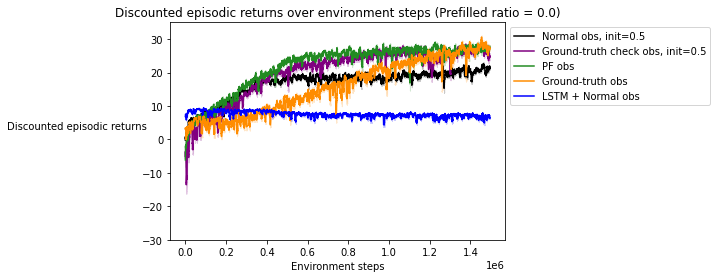

In [29]:
x = np.arange(mapped_rg.shape[1])
fig, ax = plt.figure(), plt.axes()


for key, data, color in all_data:
    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)
ax.set_ylim([-30, 35])

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Discounted episodic returns", rotation=0, labelpad=65)
ax.set_title(f'Discounted episodic returns over environment steps (Prefilled ratio = 0.0)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')


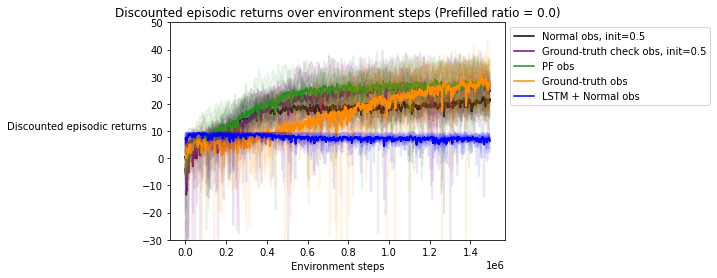

In [30]:
# Here we do individual plots and no std errors
x = np.arange(mapped_rg.shape[1])
fig, ax = plt.figure(), plt.axes()

for key, data, color in all_data:
    for d in data:
        ax.plot(x, d, color=color, alpha=0.1)
    means = data.mean(axis=0)

    ax.plot(x, means, label=key, color=color)
ax.set_ylim([-30, 50])

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Discounted episodic returns", rotation=0, labelpad=65)
ax.set_title(f'Discounted episodic returns over environment steps (Prefilled ratio = 0.0)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [28]:
# Now for rock_obs_init plots
def group_by(dataset, key):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)
        if key_val not in grouped_data:
            grouped_data[key_val] = {}
        
        grouped_data[key_val][args] = d
    return grouped_data

In [29]:
key = 'rock_obs_init'
rg_grouped_obs_init = group_by(rg_data, key)
rxg_grouped_obs_init = group_by(rxg_data, key)

In [30]:
rg_obs_init_max_overs = {}
for obs_init, d in rg_grouped_obs_init.items():
    rg_obs_init_max_overs[obs_init] = get_eps_max_over(d, eps_max_over=100)

rxg_obs_init_max_overs = {}
for obs_init, d in rxg_grouped_obs_init.items():
    rxg_obs_init_max_overs[obs_init] = get_eps_max_over(d, eps_max_over=100)

In [31]:
rg_obs_init_maxes = {}
for obs_init, d in rg_obs_init_max_overs.items():
    rg_obs_init_maxes[obs_init] = sorted(d, key=lambda x : x[1], reverse=True)[0]

rxg_obs_init_maxes = {}
for obs_init, d in rxg_obs_init_max_overs.items():
    rxg_obs_init_maxes[obs_init] = sorted(d, key=lambda x : x[1], reverse=True)[0]

In [32]:
mapped_rg_obs_init_data = {}
for obs_init, (hparams, _) in rg_obs_init_maxes.items():
    mapped_rg_obs_init_data[obs_init] = map_dis_rew_to_steps(rg_grouped_obs_init[obs_init][hparams], trunc=trunc)
    
mapped_rxg_obs_init_data = {}
for obs_init, (hparams, _) in rxg_obs_init_maxes.items():
    mapped_rxg_obs_init_data[obs_init] = map_dis_rew_to_steps(rxg_grouped_obs_init[obs_init][hparams], trunc=trunc)

In [33]:
plot_params = {
    0.: {'color': 'red'},
    0.5: {'color': 'orange'},
    1.0: {'color': 'green'}
}

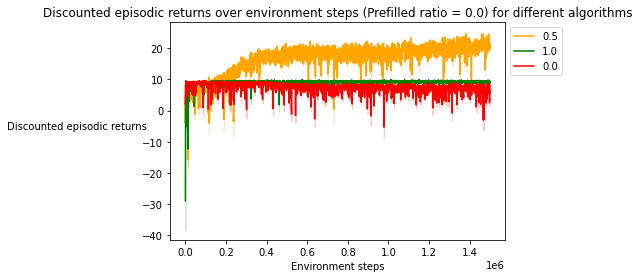

In [34]:
x_alg = np.arange(mapped_rg_obs_init_data[0.5].shape[1])
alg_fig, alg_ax = plt.figure(), plt.axes()


for key, data in mapped_rg_obs_init_data.items():
    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    alg_ax.plot(x_alg, means, label=key, color=plot_params[key]['color'])
    plt.fill_between(x_alg, means - std_err, means + std_err,
                         color=plot_params[key]['color'], alpha=0.2)

alg_ax.set_xlabel('Environment steps')
alg_ax.set_ylabel(f"Discounted episodic returns", rotation=0, labelpad=65)
alg_ax.set_title(f'Discounted episodic returns over environment steps (Prefilled ratio = 0.0) for different algorithms')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
